In [14]:
"""
Create gridded raster of distance to boundaries (e.g., from polygons) or points
    -As written, this will create a distance to CPER pasture boundaries and stock tanks on a 30 m Landsat grid
"""
import pandas as pd
import geopandas as gpd
import xarray as xr
from xrspatial import proximity
from rasterio.plot import show
from rasterio.crs import CRS
import numpy as np
import matplotlib.pyplot as plt
from lotek.conversion import shp2mask, multi2single

In [15]:
"""
Define input data
"""
cper_2017_f = 'C:/SPK_local/data/vectors/Pasture_Boundaries/Shapefiles/cper_pastures_2017_clip.shp'
cper_tanks_f = 'C:/SPK_local/data/vectors/CPER_features/Stock_Tank_V1.shp'
ras_templ_f = 'C:/SPK_local/data/rasters/HLS/HLS_quality/CPER_IGRpeak_2017.tif'

In [5]:
"""
Load files into objects
"""
ras_templ = xr.open_rasterio(ras_templ_f).squeeze()
cper = gpd.read_file(cper_2017_f)
cper_tanks = gpd.read_file(cper_tanks_f)

In [6]:
"""
Clean up pasture boundary data
"""
# rename pasture column
cper['PAST_NEW'] = cper['Past_Name_']

# rename individual pasture
cper.loc[cper['PAST_NEW'] == '21SW', 'PAST_NEW'] = '21S'

# buffer all pastures by 10 m
cper['geometry'] = cper.buffer(10)

# dissolve pasture boundaries by name
cper = cper.dissolve(by='PAST_NEW')

In [6]:
"""
Calculate distance to pasture boundaries
"""
# convert pasture shapefile to raster using .exterior to only use polygon boundaries
cper_bndry_mask = shp2mask(shp=cper.exterior, xr_object=ras_templ)

# calculate minimum distance of each grid cell to the nearest pasture boundary
cper_dist_fence = proximity(cper_bndry_mask).astype('int')

In [7]:
"""
Calculate distance to water tanks
"""
# convert point file to raster
cper_tank_mask = shp2mask(shp=cper_tanks['geometry'], xr_object=ras_templ)

# calculate minimum distance of each grid cell to the nearest water tank point
cper_dist_tank = proximity(cper_tank_mask).astype('int')

<AxesSubplot:>

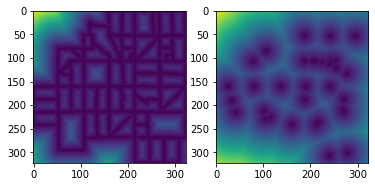

In [13]:
"""
Preview output
"""
fig, axs = plt.subplots(nrows=1, ncols=2)
show(cper_dist_fence, ax=axs[0])
show(cper_dist_tank, ax=axs[1])

In [ ]:
"""
Save rasters to file
"""
# create profile for output metadata
out_profile = {'driver': 'GTiff',
                       'dtype': 'int16',
                       'nodata': -999,
                       'width': len(ras_templ.x),
                       'height': len(ras_templ.y),
                       'count': 1,
                       'crs': CRS.from_dict(init='epsg:32613'),
                       'transform': rio.Affine(30.0, 0.0, np.min(ras_templ.x - 15.0).data,
                                               0.0, -30.0, np.max(ras_templ.y + 15.0).data),
                       'tiled': False}

# save distance to fence
with rio.open('C:/SPK_local/data/rasters/Masks/CPER_dist_to_fence_2017.tif',
              'w', **out_profile) as dst:
    dst.write(cper_dist_fence.data[np.newaxis, :, :])

# save distance to water tank
with rio.open('C:/SPK_local/data/rasters/Masks/CPER_dist_to_tank_2017.tif',
              'w', **out_profile) as dst:
    dst.write(cper_dist_tank.data[np.newaxis, :, :])